인공지능 서비스가 증가하면서 모델에서 사용하는 데이터의 양은 시간이 지날수록 기하급수적으로 늘어나고있다. 그래서 우리는 데이터와 모델의 사이즈를 줄이고자 경량화 기술을 연구한다. 

경량화 기술 중 제가 소개시켜드릴 분야는 Knowledge distillation 입니다. 딥러닝 분야에서 "지식을 증류한다"의 뜻은 Teacher Network(큰모델)로 부터 증류한 지식을 Student Network(작은 모델)로 transfer하는 과정이다. 

대표적으로 Mobilebert가 있다. 위 모델은 성능은 좋지만 모델의 사이즈가 너무큰 BERT_Large 모델에서 성능은 유지하면서 조금더 빠른 모델을 확보하기 위해 제안된 모델 이다.

In [1]:
!pip install -q pyyaml h5py

In [2]:
!pip install matplotlib

In [3]:
!pip install numpy

In [4]:
!pip install seaborn

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import os

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import seaborn as sns

In [6]:
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


In [7]:
Teacher = Sequential() 
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


Teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [8]:
myCP = ModelCheckpoint(save_best_only=True,filepath='teacher.h5',monitor = 'val_acc')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split = 0.2,
         callbacks=[myCP])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 9s 230us/sample - loss: 1.7299 - accuracy: 0.3694 - val_loss: 1.3962 - val_accuracy: 0.5132
Epoch 2/20
40000/40000 [==============================] - 9s 220us/sample - loss: 1.3810 - accuracy: 0.5030 - val_loss: 1.2198 - val_accuracy: 0.5714
Epoch 3/20
40000/40000 [==============================] - 9s 221us/sample - loss: 1.2606 - accuracy: 0.5497 - val_loss: 1.1350 - val_accuracy: 0.6028
Epoch 4/20
40000/40000 [==============================] - 9s 220us/sample - loss: 1.1732 - accuracy: 0.5818 - val_loss: 1.0740 - val_accuracy: 0.6245
Epoch 5/20
40000/40000 [==============================] - 9s 224us/sample - loss: 1.0988 - accuracy: 0.6083 - val_loss: 1.0336 - val_accuracy: 0.6382
Epoch 6/20
40000/40000 [==============================] - 9s 220us/sample - loss: 1.0475 - accuracy: 0.6279 - val_loss: 0.9828 - val_accuracy: 0.6554
Epoch 7/20
40000/40000 [==========================

In [12]:
Teacher_path = '/home/nextgen/teacher.h5'

Teacher = load_model(Teacher_path)

Teacher.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8637307558059693, 0.7037]

/home/nextgen/anaconda3/envs/distill3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nextgen/anaconda3/envs/distill3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/nextgen/anaconda3/envs/distill3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

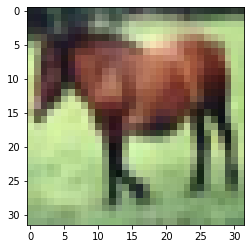

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

<Figure size 1008x432 with 0 Axes>

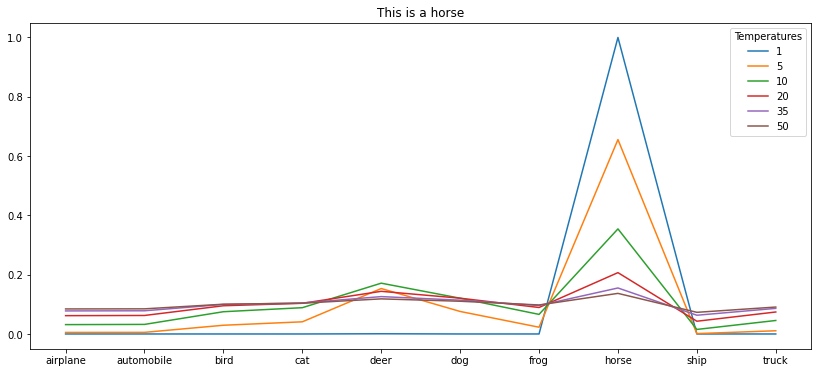

In [13]:
Teacher_logits = Model(Teacher.input,Teacher.layers[-2].output)

logits_plot = []

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]										

item_idx = 7

item_image = x_train[item_idx]

plt.imshow(item_image)

Temperatures = [1,5,10,20,35,50]


for Temperature in Temperatures:
  T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
  
  Softmax_layer = Softmax()(T_layer)

  Teacher_logits_soften = Model(Teacher.input,Softmax_layer)
                             

  logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))
  
  plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
  sns.lineplot(class_names,logits_plot[i][0],legend="full")
  plt.title('This is a '+ class_names[y_train[item_idx][0]])
  plt.legend(Temperatures,title="Temperatures")

In [14]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

In [15]:
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

In [16]:
Student = Sequential()
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
Student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [17]:
student_logits = Student.layers[-1].output

probs = Activation("softmax")(student_logits)

logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

In [18]:
def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]

  CE_loss = logloss(y_true,y_pred)

  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)
  
  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)

In [19]:
StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

In [20]:
myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 1s 28us/sample - loss: 3.5715 - accuracy: 0.2991 - val_loss: 3.1886 - val_accuracy: 0.3383
Epoch 2/50
42500/42500 [==============================] - 1s 18us/sample - loss: 3.1478 - accuracy: 0.3645 - val_loss: 3.2747 - val_accuracy: 0.3365
Epoch 3/50
42500/42500 [==============================] - 1s 18us/sample - loss: 2.9616 - accuracy: 0.3918 - val_loss: 2.9181 - val_accuracy: 0.3669
Epoch 4/50
42500/42500 [==============================] - 1s 19us/sample - loss: 2.8502 - accuracy: 0.4030 - val_loss: 2.7389 - val_accuracy: 0.3957
Epoch 5/50
42500/42500 [==============================] - 1s 19us/sample - loss: 2.7684 - accuracy: 0.4113 - val_loss: 2.7334 - val_accuracy: 0.3929
Epoch 6/50
42500/42500 [==============================] - 1s 19us/sample - loss: 2.7100 - accuracy: 0.4207 - val_loss: 2.6985 - val_accuracy: 0.3993
Epoch 7/50
42500/42500 [==============================] -

In [27]:
StudentModel.load_weights('/home/nextgen/student.h5')
StudentModel.evaluate(x_train,y_train_new)

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.193709730987549, 0.47426]

In [29]:
AloneModel = Sequential() 
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))

AloneModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 197,322
Trainable params: 197,322
Non-trainable params: 0
_________________________________________________________________


In [30]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_acc')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Train on 42500 samples, validate on 7500 samples
Epoch 1/50
42500/42500 [==============================] - 1s 20us/sample - loss: 2.0438 - accuracy: 0.2421 - val_loss: 1.9261 - val_accuracy: 0.2912
Epoch 2/50
42500/42500 [==============================] - 1s 16us/sample - loss: 1.8750 - accuracy: 0.3157 - val_loss: 1.8806 - val_accuracy: 0.3152
Epoch 3/50
42500/42500 [==============================] - 1s 16us/sample - loss: 1.8390 - accuracy: 0.3316 - val_loss: 1.8949 - val_accuracy: 0.3027
Epoch 4/50
42500/42500 [==============================] - 1s 16us/sample - loss: 1.8134 - accuracy: 0.3444 - val_loss: 1.8683 - val_accuracy: 0.3256
Epoch 5/50
42500/42500 [==============================] - 1s 17us/sample - loss: 1.7979 - accuracy: 0.3489 - val_loss: 1.8639 - val_accuracy: 0.3201
Epoch 6/50
42500/42500 [==============================] - 1s 17us/sample - loss: 1.7906 - accuracy: 0.3548 - val_loss: 1.8409 - val_accuracy: 0.3329
Epoch 7/50
42500/42500 [==============================] -

In [31]:
AloneModel = load_model("/home/nextgen/alone.h5")
AloneModel.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.7263478939056396, 0.3806]